# MiniProject 2

In [ ]:
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

## Task 1: Acquire, preprocess, and analyze the data

> Indented block



We first implement a helper function to convert text features to numerical vectors

In [ ]:
def vectorize_words(vectorizer, train_data, test_data):
    train_vectors = vectorizer.fit_transform(train_data)
    test_vectors = vectorizer.transform(test_data) 
    return train_vectors, test_vectors

### 20 news group dataset

In [ ]:
twenty_train = datasets.fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
twenty_test = datasets.fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

In [ ]:
# max_df=0.5 -> ignore terms that are found in more than 50% of documents (likely not very informative)
# stop_words='english' -> ignore common english words such as 'the', 'and', 'him'
twenty_vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english')
twenty_train_vectors, twenty_test_vectors = vectorize_words(twenty_vectorizer, twenty_train.data, twenty_test.data)

twenty_train_vectors
twenty_test_vectors

<7532x10441 sparse matrix of type '<class 'numpy.float64'>'
	with 370362 stored elements in Compressed Sparse Row format>

### Sentiment140 dataset

In [ ]:
!wget "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
!unzip trainingandtestdata.zip

--2022-03-07 02:51:46--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2022-03-07 02:51:46--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  81.5MB/s    in 1.0s    

2022-03-07 02:51:47 (81.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
sentiment_train = pd.read_csv("training.1600000.processed.noemoticon.csv", names = ["POLARITY", "ID", "DATE", "QUERY", "USER", "TEXT"], encoding='latin-1')
sentiment_test = pd.read_csv("testdata.manual.2009.06.14.csv", names = ["POLARITY", "ID", "DATE", "QUERY", "USER", "TEXT"], encoding='latin-1')

In [ ]:
# replace all polarities of 4 to 1
sentiment_train.loc[sentiment_train['POLARITY'] == 4, 'POLARITY'] = 1
sentiment_test.loc[sentiment_test['POLARITY'] == 4, 'POLARITY'] = 1

# delete rows having 2 as a polarity in test set
sentiment_test.drop(sentiment_test[sentiment_test['POLARITY'] == 2].index, inplace=True)

sentiment_test

,POLARITY,ID,DATE,QUERY,USER,TEXT
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
492,1,14071,Sun Jun 14 04:31:28 UTC 2009,latex,yomcat,"After using LaTeX a lot, any other typeset mat..."
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,1,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [ ]:
# max_df=0.5 -> ignore terms that are found in more than 50% of documents (likely not very informative)
# stop_words='english' -> ignore common english words such as 'the', 'and', 'him'
sentiment_vectorizer = TfidfVectorizer(max_df=0.5, min_df=40, stop_words='english')
sentiment_train_vectors, sentiment_test_vectors = vectorize_words(sentiment_vectorizer, sentiment_train['TEXT'], sentiment_test['TEXT'])

## Task 2: Implement Naive Bayes and k-fold cross validation

### Naive Bayes implementation

We will use a multinomial naive bayes model, as we are dealing with word counts, which are discrete. However, it turns out that multinomial naive bayes also works with tf-idf vectors, even if they have continuous features. For the likelihood function, we add up all the occurrences (or frequencies) of a particular word in the documents of a same class, and divide by the total number of words in that class to get a probability. The only hyperparameter is alpha, which determines how many "fake" occurrences of words are added to the training set for Laplace smoothing.

In [ ]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha

    def fit(self, x, y):
        self.num_training_examples, self.num_features = x.shape
        self.num_classes = np.max(y) + 1
        self.prior = self._get_prior(y)
        self.conditional_probs = self._get_feature_likelihood(x, y)

    def predict(self, test_set):
        predictions = []
        test_set = test_set.toarray()
        num_test_examples = test_set.shape[0]
        for n in range(num_test_examples):
            class_probabilities = []
            # Calculate the probability of this test example being in class c
            for c in range(self.num_classes):
                class_probabilities.append(self.prior[c] * np.prod(self._get_test_prob_given_class(test_set[n], c)))

            # Get the class with the highest probability
            predictions.append(np.argmax(class_probabilities))

        return predictions

    def _get_test_prob_given_class(self, test, c):
        word_probabilities = []
        for i in range(len(test)):
            # test[i] is the number of times a word appears in the test document
            # we therefore raise the probability of this word to the power of the number of 
            # times it appears
            word_probabilities.append(self.conditional_probs[c][i]**test[i]) 
        return word_probabilities

    def _get_prior(self, y):
        # The prior is the probability of an arbitrary document being in a given class
        prior = []
        for c in range(self.num_classes):
            class_occurrences = np.count_nonzero(y == c)
            prior.append(class_occurrences / self.num_training_examples)
        return prior

    def _get_feature_likelihood(self, x, y):
        # For the likelihood function, we add up word counts or frequencies for each category
        # We then divide this number by the total number of words or frequencies in the category to get a probability
        word_probabilities = np.zeros((self.num_classes, self.num_features))
        for c in range(self.num_classes):
            # Get all training examples that belong to class c
            x_in_c = x[y == c]
            x_in_c = x_in_c.toarray()
            # Add up word count or frequency for every feature
            x_sum = np.sum(x_in_c, axis=0)
            # Add up the total number of words or frequencies in the class
            x_total = np.sum(x_sum)
            # Use the alpha smoothing factor to avoid 0 probabilities for words that are not in a class
            word_probabilities[c] = (x_sum + self.alpha) / (x_total + self.alpha * self.num_features)

        return word_probabilities


We implement a simple accuracy evaluation function that compares the predicted values to the expected values.

In [ ]:
def evaluate_acc(predictions, expected):
    return 100 * np.mean(predictions == expected)


### K-fold cross validation implementation

To help with hyper-parameter tuning and model selection, we implement k-fold cross-validation. The class takes in the parameter k, which determines how many folds will be performed

In [ ]:
class KFoldCrossValidation:
    def __init__(self, k=5):
        self.k = k

    def cross_validation_split(self, train_size):
        # get number of data samples in each split
        fold_size = train_size // self.k
        # We will keep track of validation start and end indices, so we can easily slice
        # our train set
        # We also keep a list of the train indices
        validation_indices = []
        train_indices = []

        for i in range(self.k):
            validation_start = i * fold_size
            # Ensure we are not at the last fold
            if i < self.k - 1:
                validation_end = validation_start + fold_size
            else:
                validation_end = train_size
            
            validation_indices.append((validation_start, validation_end))
            train_indices.append(list(range(0,validation_start)) + list(range(validation_end, train_size)))

        self.validation_indices = validation_indices
        self.train_indices = train_indices

    def kfoldCV(self, model, x, y):
        accuracies = []
        for i in range(self.k):
            validation_set_data = x[self.validation_indices[i][0]:self.validation_indices[i][1]]
            validation_set_target = y[self.validation_indices[i][0]:self.validation_indices[i][1]]

            train_set_data = x[self.train_indices[i]]
            train_set_target = y[self.train_indices[i]]

            model.fit(train_set_data, train_set_target)
            predictions = model.predict(validation_set_data)

            accuracy = evaluate_acc(predictions, validation_set_target)
            print(f'test accuracy: {accuracy}%')
            accuracies.append(accuracy)

        return accuracies



    

In [ ]:
def perform_kfold_cross_validation(model, training_size, num_folds, train_data, target_data):
    validator = KFoldCrossValidation(k=num_folds)
    validator.cross_validation_split(training_size)
    return validator.kfoldCV(model, train_data[:training_size], target_data[:training_size])

### Hyper-parameter tuning on 20 news group dataset

Our implementation of Naive Bayes has only one hyper-parameter, alpha. Thus, we will run 5-fold cross validation on a few different values of alpha.

In [ ]:
# CELL TAKES A VERY LONG TIME TO RUN
twenty_accuracies_list = []
alpha_values = list(range(1, 5))
for i in alpha_values:
    model = MultinomialNaiveBayes(alpha=i)
    accuracies = perform_kfold_cross_validation(model, 5000, 10, twenty_train_vectors, twenty_train.target)
    twenty_accuracies_list.append(accuracies)


test accuracy: 67.60000000000001%
test accuracy: 69.39999999999999%
test accuracy: 64.4%
test accuracy: 71.0%
test accuracy: 66.4%
test accuracy: 68.4%
test accuracy: 65.60000000000001%
test accuracy: 66.8%
test accuracy: 71.39999999999999%
test accuracy: 66.60000000000001%
test accuracy: 64.2%
test accuracy: 67.60000000000001%
test accuracy: 63.4%
test accuracy: 70.6%
test accuracy: 65.2%
test accuracy: 66.0%
test accuracy: 64.2%
test accuracy: 64.4%
test accuracy: 70.0%
test accuracy: 65.60000000000001%
test accuracy: 63.0%
test accuracy: 66.2%
test accuracy: 61.8%
test accuracy: 70.19999999999999%
test accuracy: 62.8%
test accuracy: 64.60000000000001%
test accuracy: 63.2%
test accuracy: 63.0%
test accuracy: 68.4%
test accuracy: 65.2%
test accuracy: 61.8%
test accuracy: 64.4%
test accuracy: 61.0%
test accuracy: 69.6%
test accuracy: 62.4%
test accuracy: 63.800000000000004%
test accuracy: 62.6%
test accuracy: 61.6%
test accuracy: 68.4%
test accuracy: 62.8%


We implement a helper function to plot our results

In [ ]:
def show_hyper_param_graph(hyper_values, accuracies, xlabel):
    plt.errorbar(hyper_values, np.mean(accuracies, axis=1), np.std(accuracies, axis=1,), label='validation')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy %')
    plt.show

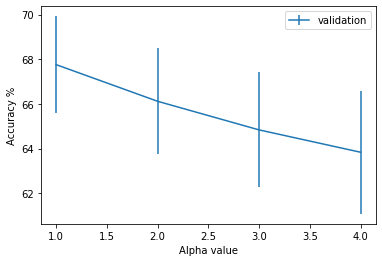

In [ ]:
show_hyper_param_graph(alpha_values, twenty_accuracies_list, 'Alpha value')

Other possible tests would include simply using the count vectorizer instead of the tf-idf vectorizer, and playing with the parameters of these vectors.

Since our implementation of Naive Bayes already takes a very long time to run with the 20 news group dataset, we will omit doing hyper-parameter tuning on the sentiment140 dataset and simply set alpha to 1. This value yielded the best results with the 20 news group dataset.

### Results on the test sets

20 news group dataset. Our implementation takes about 20 minutes to run predictions on the full test set, so we recommand only taking a subset of the testing set

In [ ]:
# Takes very long to run
model = MultinomialNaiveBayes(alpha=1)
model.fit(twenty_train_vectors, twenty_train.target)
predictions = model.predict(twenty_test_vectors)
print(f'Accuracy: {evaluate_acc(predictions, twenty_test.target)}')

Accuracy: 67.6048858204992


For the sentiment140 dataset, we only use a subset of our training data, as our implementation of mulinomial naive bayes would be too slow otherwise

In [ ]:
model = MultinomialNaiveBayes(alpha=1)
model.fit(sentiment_train_vectors[:50000], sentiment_train['POLARITY'][:50000])
predictions = model.predict(sentiment_test_vectors[:2000])
print(f'Accuracy: {evaluate_acc(predictions, sentiment_test["POLARITY"][:2000])}')

Accuracy: 49.30362116991643


This rather low accuracy can be explained by the fact that we only use a subset of the training data. Thus, many words in the test set will not have appeared in the training subset.

## Task 3: Run experiments

Since our implementation of Naive Bayes runs very slowly, we will use Sklearn's implementation for part 3 of the assignment

### Hyper-parameter tuning for 20 news group dataset

#### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# We only test the alpha value
twenty_accuracies_list1 = []
alpha_values = list(range(1, 10))
for i in alpha_values:
    model = MultinomialNB(alpha=i)
    accuracies = perform_kfold_cross_validation(model, len(twenty_train.data), 5, twenty_train_vectors, twenty_train.target)
    twenty_accuracies_list1.append(accuracies)

test accuracy: 71.17595048629532%
test accuracy: 68.52343059239611%
test accuracy: 71.26436781609196%
test accuracy: 72.98850574712644%
test accuracy: 71.00617828773169%
test accuracy: 70.15915119363395%
test accuracy: 67.41821396993811%
test accuracy: 69.84969053934572%
test accuracy: 72.06012378426172%
test accuracy: 68.71138570167696%
test accuracy: 69.67285587975243%
test accuracy: 66.93191865605658%
test accuracy: 68.52343059239611%
test accuracy: 70.99911582670202%
test accuracy: 67.07855251544572%
test accuracy: 68.56763925729443%
test accuracy: 66.04774535809018%
test accuracy: 67.72767462422635%
test accuracy: 70.33598585322723%
test accuracy: 65.62224183583407%
test accuracy: 67.68346595932803%
test accuracy: 65.25198938992042%
test accuracy: 67.10875331564988%
test accuracy: 69.76127320954907%
test accuracy: 64.9602824360106%
test accuracy: 67.06454465075154%
test accuracy: 64.67727674624226%
test accuracy: 66.62245800176835%
test accuracy: 69.54022988505747%
test accuracy: 

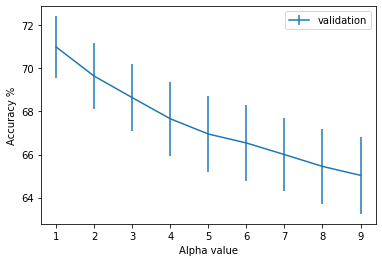

In [ ]:
show_hyper_param_graph(alpha_values, twenty_accuracies_list1, 'Alpha value')

The best value of alpha for the 20 news group dataset seems to be 1.

#### Softmax Regression

In [ ]:
# With different C values
from sklearn.linear_model import LogisticRegression
twenty_accuracies_list2 = []
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in c_values:
    model = LogisticRegression(C=i, random_state=0)
    accuracies = perform_kfold_cross_validation(model, len(twenty_train.data), 5, twenty_train_vectors, twenty_train.target)
    twenty_accuracies_list2.append(accuracies)

test accuracy: 67.50663129973475%
test accuracy: 65.73828470380194%
test accuracy: 66.00353669319186%
test accuracy: 69.09814323607428%
test accuracy: 65.26919682259488%
test accuracy: 69.62864721485411%
test accuracy: 68.34659593280283%
test accuracy: 69.14235190097259%
test accuracy: 70.6896551724138%
test accuracy: 67.96116504854369%
test accuracy: 70.33598585322723%
test accuracy: 69.49602122015915%
test accuracy: 70.55702917771883%
test accuracy: 71.70645446507515%
test accuracy: 69.77052074139452%
test accuracy: 70.77807250221043%
test accuracy: 69.71706454465075%
test accuracy: 71.131741821397%
test accuracy: 72.45800176834659%
test accuracy: 70.43248014121801%
test accuracy: 71.17595048629532%
test accuracy: 70.33598585322723%
test accuracy: 71.70645446507515%
test accuracy: 72.72325375773652%
test accuracy: 71.00617828773169%
test accuracy: 71.44120247568524%
test accuracy: 70.64544650751547%
test accuracy: 71.75066312997347%
test accuracy: 73.03271441202476%
test accuracy: 71

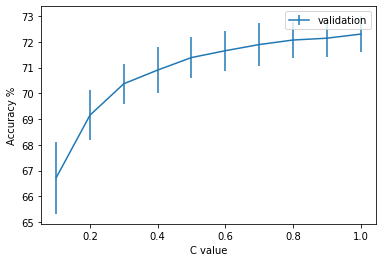

In [ ]:
show_hyper_param_graph(c_values, twenty_accuracies_list2, 'C value')

In [ ]:
# With different intercept_scaling values
twenty_accuracies_list3 = []
intercept_scaling_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in intercept_scaling_values:
    model = LogisticRegression(intercept_scaling=i, random_state=0)
    accuracies = perform_kfold_cross_validation(model, len(twenty_train.data), 5, twenty_train_vectors, twenty_train.target)
    twenty_accuracies_list3.append(accuracies)

test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy: 71.93292144748456%
test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy: 71.93292144748456%
test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy: 71.93292144748456%
test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy: 71.93292144748456%
test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy: 71.93292144748456%
test accuracy: 72.45800176834659%
test accuracy: 71.44120247568524%
test accuracy: 72.14854111405835%
test accuracy: 73.51900972590629%
test accuracy:

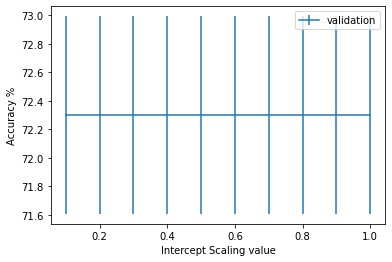

In [ ]:
show_hyper_param_graph(intercept_scaling_values, twenty_accuracies_list3, 'Intercept Scaling value')

The best value of C seems to be 1.0, and the best intercept scaling value seems to be 1.0.

### Hyper-parameter tuning for sentiment140 dataset

#### Multinomial Naive Bayes

In [ ]:
# We only test the alpha value
sentiment_accuracies_list4 = []
alpha_values = list(range(1, 10))
for i in alpha_values:
    model = MultinomialNB(alpha=i)
    accuracies = perform_kfold_cross_validation(model, len(sentiment_train["TEXT"]), 5, sentiment_train_vectors, sentiment_train["POLARITY"])
    sentiment_accuracies_list4.append(accuracies)

test accuracy: 50.87625%
test accuracy: 52.893125%
test accuracy: 75.38312499999999%
test accuracy: 50.9634375%
test accuracy: 49.987187500000005%
test accuracy: 50.6875%
test accuracy: 52.6884375%
test accuracy: 75.439375%
test accuracy: 50.666875%
test accuracy: 49.745%
test accuracy: 50.464375%
test accuracy: 52.46031249999999%
test accuracy: 75.47749999999999%
test accuracy: 50.3153125%
test accuracy: 49.401250000000005%
test accuracy: 50.222187500000004%
test accuracy: 52.2121875%
test accuracy: 75.52375%
test accuracy: 49.988437499999996%
test accuracy: 49.1075%
test accuracy: 50.0140625%
test accuracy: 51.9615625%
test accuracy: 75.5584375%
test accuracy: 49.658437500000005%
test accuracy: 48.7953125%
test accuracy: 49.7821875%
test accuracy: 51.69625%
test accuracy: 75.5846875%
test accuracy: 49.329375%
test accuracy: 48.470625%
test accuracy: 49.5409375%
test accuracy: 51.44499999999999%
test accuracy: 75.5965625%
test accuracy: 48.988749999999996%
test accuracy: 48.098125%
te

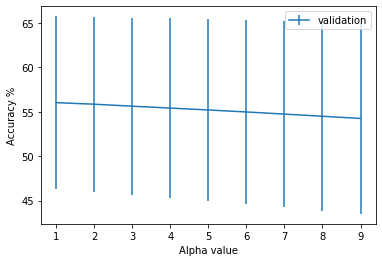

In [ ]:
show_hyper_param_graph(alpha_values, sentiment_accuracies_list4, 'Alpha value')

The best value of alpha seem to be 1.

#### Softmax Regression

In [ ]:
# With different C values
sentiment_accuracies_list5 = []
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in c_values:
    model = LogisticRegression(C=i, random_state=0)
    accuracies = perform_kfold_cross_validation(model, len(sentiment_train["TEXT"]), 5, sentiment_train_vectors, sentiment_train["POLARITY"])
    sentiment_accuracies_list5.append(accuracies)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 58.34%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.363125%
test accuracy: 76.8496875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 63.151562500000004%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.143125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 59.4240625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 61.43875%
test accuracy: 76.9571875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5984375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 63.455625000000005%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 59.739374999999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 61.948125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.91781250000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.1575%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.1946875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.017187500000006%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.259687500000005%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.9125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.13375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.3409375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.32062500000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.33%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.918125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.4440625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.4771875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.3275%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.551875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.9053125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.393125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.468125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.6665625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.761562500000004%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.9015625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.4934375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.66375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.3996875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.870937500000004%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.8878125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 66.2721875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.8328125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.533125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.677499999999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.8809375%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.7146875%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.760625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%
test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


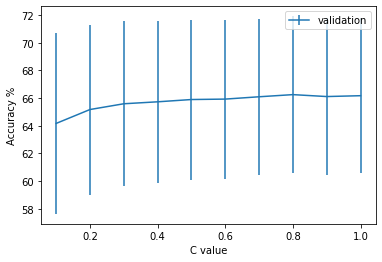

In [ ]:
show_hyper_param_graph(c_values, sentiment_accuracies_list5, 'C value')

In [ ]:
# With different intercept_scaling values
sentiment_accuracies_list6 = []
intercept_scaling_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in intercept_scaling_values:
    model = LogisticRegression(intercept_scaling=i, random_state=0)
    accuracies = perform_kfold_cross_validation(model, len(sentiment_train["TEXT"]), 5, sentiment_train_vectors, sentiment_train["POLARITY"])
    sentiment_accuracies_list6.append(accuracies)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 60.69625%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 62.810312499999995%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 76.86%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


test accuracy: 65.94250000000001%
test accuracy: 64.5653125%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


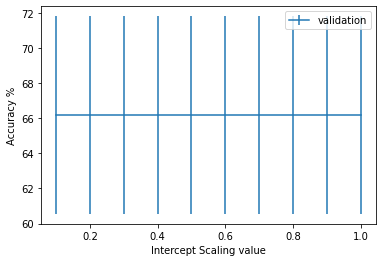

In [ ]:
show_hyper_param_graph(intercept_scaling_values, sentiment_accuracies_list6, 'Intercept Scaling value')

The best C value seems to be 0.8, and the best intercept scaling value seems to be 1.0.

### Comparing the results

20 news group dataset

In [ ]:
naive_bayes_model = MultinomialNB(alpha=1)
softmax_regression_model = LogisticRegression(C=1, intercept_scaling=1)

naive_bayes_model.fit(twenty_train_vectors, twenty_train.target)
predictions = naive_bayes_model.predict(twenty_test_vectors)
twenty_accuracy_naive = evaluate_acc(predictions, twenty_test.target)

softmax_regression_model.fit(twenty_train_vectors, twenty_train.target)
predictions = softmax_regression_model.predict(twenty_test_vectors)
twenty_accuracy_softmax = evaluate_acc(predictions, twenty_test.target)

Sentiment140 dataset

In [ ]:
naive_bayes_model2 = MultinomialNB(alpha=1)
softmax_regression_model2 = LogisticRegression(C=0.8, intercept_scaling=1)

naive_bayes_model2.fit(sentiment_train_vectors, sentiment_train["POLARITY"])
predictions2 = naive_bayes_model2.predict(sentiment_test_vectors)
sent_accuracy_naive = evaluate_acc(predictions2, sentiment_test["POLARITY"])

softmax_regression_model2.fit(sentiment_train_vectors, sentiment_train["POLARITY"])
predictions2 = softmax_regression_model2.predict(sentiment_test_vectors)
sentiment_accuracy_softmax = evaluate_acc(predictions2, sentiment_test["POLARITY"])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
columns = ['Model', '20 news group accuracy', 'Sentiment140 accuracy', 'Overall accuracy']
data = [
        ['Multinomial Naive Bayes', twenty_accuracy_naive, sent_accuracy_naive, (twenty_accuracy_naive + sent_accuracy_naive)/2],
        ['Softmax Regression', twenty_accuracy_softmax, sentiment_accuracy_softmax, (twenty_accuracy_softmax + sentiment_accuracy_softmax)/2]
]
pd.DataFrame(columns=columns, data=data)

,Model,20 news group accuracy,Sentiment140 accuracy,Overall accuracy
0,Multinomial Naive Bayes,67.604886,80.779944,74.192415
1,Softmax Regression,67.087095,81.615599,74.351347


Better performimg model for 20 news group dastaset was Multinomial Naive Bayes.
Better performing model for Sentiment140 dataset was Softmax Regression.
Best overall performing model was Softmax regression.

### Accuracy based on different data size

In [ ]:
percentages_to_test = [20, 40, 60, 80]

In [ ]:
def draw_percentage_graph(accuracies):
    plt.scatter(percentages_to_test, accuracies)
    plt.plot(percentages_to_test, accuracies)
    plt.xlabel("% of Training Data")
    plt.ylabel("Accuracy")
    plt.show()

#### 20 news group

In [ ]:
def test_with_percentage_twenty(percentage, model):
    nb_train_data = int((percentage / 100) * len(twenty_train.data))

    random_train_indices = np.random.permutation(len(twenty_train.data))

    x_train_subset = [twenty_train.data[i] for i in random_train_indices[:nb_train_data]]
    y_train_subset = [twenty_train.target[i] for i in random_train_indices[:nb_train_data]]

    vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english')
    train_vectors, test_vectors = vectorize_words(vectorizer, x_train_subset, twenty_test.data)

    model.fit(train_vectors, y_train_subset)
    predictions = model.predict(test_vectors)

    accuracy = evaluate_acc(predictions, twenty_test.target)

    return accuracy

##### Multinomial Naive Bayes

In [ ]:
average_accuracies_twenty_nb = []

for percentage in percentages_to_test:
    accuracies = []
    for i in range(5):
        model = MultinomialNB(alpha=1)
        accuracies.append(test_with_percentage_twenty(percentage, model))
    average_accuracies_twenty_nb.append(np.mean(accuracies))

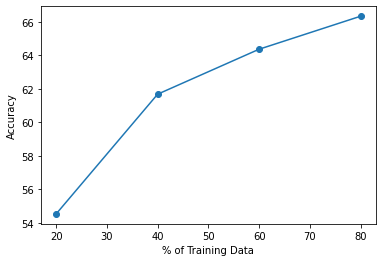

In [ ]:
draw_percentage_graph(average_accuracies_twenty_nb)

##### Softmax Regression

In [ ]:
average_accuracies_twenty_sr = []

for percentage in percentages_to_test:
    accuracies = []
    for i in range(5):
        model = LogisticRegression(C=0.8, intercept_scaling=1)
        accuracies.append(test_with_percentage_twenty(percentage, model))
    average_accuracies_twenty_sr.append(np.mean(accuracies))

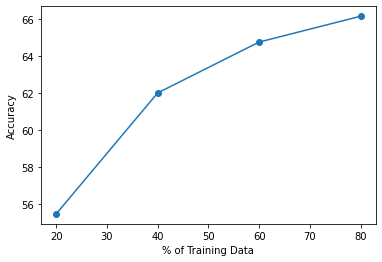

In [ ]:
draw_percentage_graph(average_accuracies_twenty_sr)

Both models behave very similarly when working on a subset of the train data. However, softmax regression seems to have a slight edge over Naive Bayes at lower percentages, while Naive Bayes performs slightly better when reaching higher percentages.

#### Sentiment140

In [ ]:
def test_with_percentage_sentiment140(percentage, model):
    float_percent = percentage / 100
    train_df = sentiment_train.sample(frac=float_percent)

    vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english')
    train_vectors, test_vectors = vectorize_words(vectorizer, train_df['TEXT'], sentiment_test['TEXT'])

    model.fit(train_vectors, train_df['POLARITY'])
    predictions = model.predict(test_vectors)

    accuracy = evaluate_acc(predictions, sentiment_test['POLARITY'])

    return accuracy


##### Multinomial Naive Bayes

In [ ]:
average_accuracies_sentiment_nb = []

for percentage in percentages_to_test:
    accuracies = []
    for i in range(3):
        model = MultinomialNB(alpha=1)
        accuracies.append(test_with_percentage_sentiment140(percentage, model))
    average_accuracies_sentiment_nb.append(np.mean(accuracies))

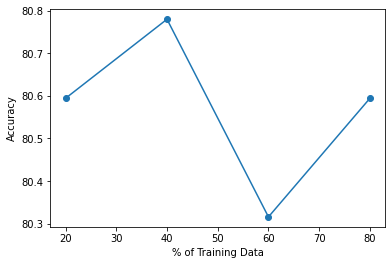

In [ ]:
draw_percentage_graph(average_accuracies_sentiment_nb)

##### Softmax Regression

In [ ]:
average_accuracies_sentiment_sr = []

for percentage in percentages_to_test:
    accuracies = []
    for i in range(3):
        model = LogisticRegression(C=0.8, intercept_scaling=1)
        accuracies.append(test_with_percentage_sentiment140(percentage, model))
    average_accuracies_sentiment_sr.append(np.mean(accuracies))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


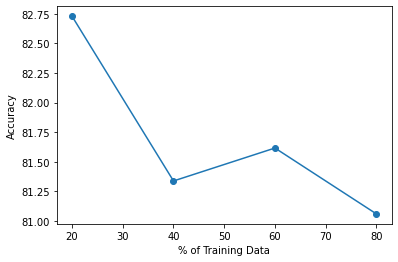

In [ ]:
draw_percentage_graph(average_accuracies_sentiment_sr)

For the Sentiment140 dataset, the size of the training set does not seem to affect the accuracy very much. 20% of the training data is still more than 300,000 documents, and each document is rather short. This means that a good vocabulary that covers most important words can be established with a subset of the trainig data. It is also worth noting that there are only 2 classes in the sentiment140 dataset compared to the 20 in the 20 news group dataset